Imports and setup

In [1]:
import pickle
import numpy as np
from rdkit import Chem
import rdkit.Chem.QED
import torch
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.regression.basic_due import basic_due
from coati.common.util import batch_indexable

# set your device
DEVICE = torch.device("cuda:0")

Load model

In [2]:
# Model parameters are pulled from the url and stored in a local models/ dir.
encoder, tokenizer = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=DEVICE,
    # model parameters to load.
    doc_url="s3://terray-public/models/barlow_closed.pkl",
)

Loading model from s3://terray-public/models/barlow_closed.pkl
Loading tokenizer may_closedparen from s3://terray-public/models/barlow_closed.pkl
number of parameters: 12.64M
number of parameters Total: 2.44M xformer: 17.92M Total: 20.36M 
vocab_name not found in tokenizer_vocabs, trying to load from file
Freezing encoder
20561664 params frozen!


Visualize tokens and likelihood

In [3]:
def tokens_to_likelihood(
    encoder,
    smiles,
    tokenizer,
    prefix="[CLIP][UNK][SMILES]",
    emb_vector=None,
    print_loss=False,
):
    """
    Simply computes the log likelihood for a given prefix and smiles.

    The prefix can include the [CLIP] token, where [UNK] be replaced with the
    embedding vector.
    """
    tokens = tokenizer.tokenize_text(prefix + smiles + "[STOP]", pad=False)
    tokens = torch.tensor(tokens, device=encoder.device, dtype=torch.long).unsqueeze(0)
    y_next = torch.zeros_like(tokens)
    # shift the tokens to the left by one
    y_next[:, : (tokens.shape[1] - 1)] = tokens[:, 1:].clone()
    # identify the tokens to ignore
    y_next[y_next == tokenizer.clip_token] = -1
    y_next[y_next == tokenizer.pad_token] = -1
    y_next[y_next == tokenizer.smiles_token] = -1
    y_next[y_next == tokenizer.unk_token] = -1
    y_next[y_next == tokenizer.suffix_token] = -1
    y_next[y_next == tokenizer.middle_token] = -1
    # Get the logits from the transformer.
    if "[CLIP]" in prefix:
        # If the prefix includes [CLIP], then we replace the [UNK] token with
        # the embedding vector.
        logits = encoder.xformer.forward_with_replacement(
            tokens,
            encoder.point_clip_to_special_tokens(emb_vector.unsqueeze(0)),
            tokenizer,
        )
    else:
        # Otherwise, we just run the transformer.
        logits = encoder.xformer.forward(tokens)

    # Compute the autoregressive (AR) losses, log P(x_i|x_{j<i}), which can be
    # found from cross_entropy.
    # Ignore the special tokens.
    ar_loss = torch.nn.functional.cross_entropy(
        logits.view(-1, logits.size(-1)),
        y_next.view(-1),
        ignore_index=-1,
        reduction="none",
    ).reshape(tokens.shape)
    ar_loss[y_next == -1] = 0
    if print_loss:
        print("tokens: ", tokens.flatten().tolist())
        print(
            tokenizer.decode(
                tokens.flatten().tolist(),
                color_loss=[0] + ((ar_loss.flatten().tolist())[:-1]),
            )
        )
    # log-likelihood, log P(x), is the sum over the log-conditionals.
    return ar_loss.sum(-1)

In the following, low &rarr; high log-conditionals are illustrated with Blue &rarr; Red token coloring.

We first start with conditioning our input with a smiles string embedding vector. We use the fentanyl molecule as an example.

In [4]:
from coati.generative.coati_purifications import embed_smiles

# get the canonical smiles for fentanyl.
fentanyl_smiles = "CCC(=O)N(C1CCN(CC1)CCC2=CC=CC=C2)C3=CC=CC=C3"
fentanyl_canonical_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(fentanyl_smiles))

fentanyl_vector = embed_smiles(fentanyl_canonical_smiles, encoder, tokenizer)

log_likelihood = tokens_to_likelihood(
    encoder,
    fentanyl_canonical_smiles,
    tokenizer,
    prefix="[CLIP][UNK][SMILES][SUFFIX][MIDDLE]",
    emb_vector=fentanyl_vector,
    print_loss=True,
)

print(f"log likelihood: {log_likelihood.item():.3f}")

tokens:  [8, 7, 2, 5, 6, 3371, 4914, 6445, 1598, 8612, 1597, 1876, 1]
[CLIP][UNK][SMILES][SUFFIX][MIDDLE]CCC(=O)N(c1ccccc1)C1CCN(CCc2ccccc2)CC1[STOP]
log likelihood: 0.117


In [5]:
log_likelihood = tokens_to_likelihood(
    encoder,
    fentanyl_canonical_smiles,
    tokenizer,
    prefix="[CLIP][UNK][SMILES]",
    emb_vector=fentanyl_vector,
    print_loss=True,
)

print(f"log likelihood: {log_likelihood.item():.3f}")

tokens:  [8, 7, 2, 3371, 4914, 6445, 1598, 8612, 1597, 1876, 1]
[CLIP][UNK][SMILES]CCC(=O)N(c1ccccc1)C1CCN(CCc2ccccc2)CC1[STOP]
log likelihood: 0.127


Without conditioning, this particular smiles is much less likely.

In [6]:
# unconditioned log-likelihood. Note we do not pass in the embedding vector.

log_likelihood = tokens_to_likelihood(
    encoder, fentanyl_canonical_smiles, tokenizer, prefix="[SMILES]", print_loss=True
)

print(f"log likelihood: {log_likelihood.item():.3f}")

tokens:  [2, 3371, 4914, 6445, 1598, 8612, 1597, 1876, 1]
[SMILES]CCC(=O)N(c1ccccc1)C1CCN(CCc2ccccc2)CC1[STOP]
log likelihood: 23.376


In [7]:
log_likelihood = tokens_to_likelihood(
    encoder,
    fentanyl_canonical_smiles,
    tokenizer,
    prefix="[SMILES][SUFFIX][MIDDLE]",
    print_loss=True,
)

print(f"log likelihood: {log_likelihood.item():.3f}")

tokens:  [2, 5, 6, 3371, 4914, 6445, 1598, 8612, 1597, 1876, 1]
[SMILES][SUFFIX][MIDDLE]CCC(=O)N(c1ccccc1)C1CCN(CCc2ccccc2)CC1[STOP]
log likelihood: 23.498


Statistics and analysis on Chembl dataset

In [8]:
from coati.common.s3 import cache_read

# load Chembl dataset smile strings.
with cache_read("s3://terray-public/datasets/chembl_canonical_smiles.pkl", "rb") as f:
    chembl_canonical_smiles = pickle.loads(f.read(), encoding="UTF-8")

For a random subset of Chembl smiles, we compute the conditioned and unconditioned log likelihoods.

In [9]:
import random

# note: the result in the paper used 50_000 samples.
random.shuffle(chembl_canonical_smiles)
subset = chembl_canonical_smiles[:5000]

batch_size = 100
conditioned_likes = []
unconditioned_likes = []
for i, smiles in enumerate(subset):
    if i % batch_size == 0:
        print(f"batch: {i//100}/{len(subset) // batch_size}")
    try:
        emb_vector = embed_smiles(smiles, encoder, tokenizer)
        log_likelihood = tokens_to_likelihood(
            encoder,
            smiles,
            tokenizer,
            prefix="[CLIP][UNK][SMILES][SUFFIX][MIDDLE]",
            emb_vector=emb_vector,
            print_loss=False,
        )
        conditioned_likes.append(log_likelihood.detach().cpu().item())
    except Exception as Ex:
        conditioned_likes.append(np.nan)

    try:
        log_likelihood = tokens_to_likelihood(
            encoder,
            smiles,
            tokenizer,
            prefix="[SMILES][SUFFIX][MIDDLE]",
            print_loss=False,
        )
        unconditioned_likes.append(log_likelihood.detach().cpu().item())
    except Exception as Ex:
        unconditioned_likes.append(np.nan)

batch: 0/50
batch: 1/50
batch: 2/50
batch: 3/50
batch: 4/50
batch: 5/50
batch: 6/50
batch: 7/50
batch: 8/50
batch: 9/50
batch: 10/50
batch: 11/50
batch: 12/50
batch: 13/50
batch: 14/50
batch: 15/50
batch: 16/50
batch: 17/50
batch: 18/50
batch: 19/50
batch: 20/50
batch: 21/50
batch: 22/50
batch: 23/50
batch: 24/50
batch: 25/50
batch: 26/50
batch: 27/50
batch: 28/50
batch: 29/50
batch: 30/50
batch: 31/50
batch: 32/50
batch: 33/50
batch: 34/50
batch: 35/50
batch: 36/50
batch: 37/50
batch: 38/50
batch: 39/50
batch: 40/50
batch: 41/50
batch: 42/50
batch: 43/50
batch: 44/50
batch: 45/50
batch: 46/50
batch: 47/50
batch: 48/50
batch: 49/50


We plot a histogram of the log-likelihoods for the conditioned and unconditioned results.

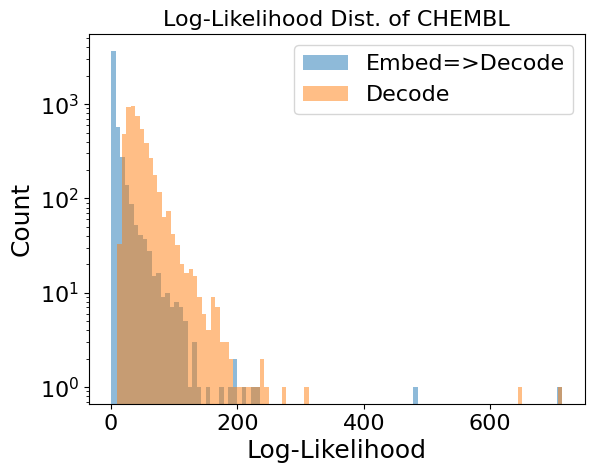

In [10]:
import matplotlib
import matplotlib.pyplot as plt

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

matplotlib.rc("font", family="sans-serif")
matplotlib.rc("font", serif="Helvetica Neue")
matplotlib.rc("text", usetex="false")


plt.hist(
    [x for x in conditioned_likes if not np.isnan(x)],
    bins=100,
    log=True,
    alpha=0.5,
    label="Embed=>Decode",
)
plt.hist(
    [x for x in unconditioned_likes if not np.isnan(x)],
    bins=100,
    log=True,
    alpha=0.5,
    label="Decode",
)
plt.title("Log-Likelihood Dist. of CHEMBL")
plt.legend()
plt.xlabel("Log-Likelihood")
plt.ylabel("Count")
plt.show()

Clearly, embedding the smiles vector in the prefix will yields much more likely results.

In [11]:
mean_cl = np.mean([x for x in conditioned_likes if not np.isnan(x)])
mean_ucl = np.mean([x for x in unconditioned_likes if not np.isnan(x)])

print(f"mean conditioned log-likelihood, <decode>: {mean_cl:.3f}")
print(f"mean unconditioned log-likelihood, <embed, decode>: {mean_ucl:.3f}")

mean conditioned log-likelihood, <decode>: 8.075
mean unconditioned log-likelihood, <embed, decode>: 45.245


We can view the log-likehoods for the conditioned and unconditioned approach in the following scatter plot. Corresponding frequency histograms are shown on the x and y axes.

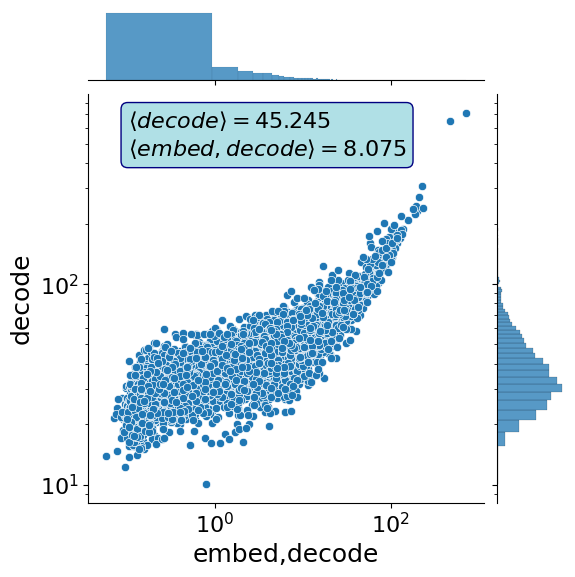

In [12]:
import seaborn as sns
import pandas as pd

tofrm = []
for i in range(len(unconditioned_likes)):
    if not (np.isnan(unconditioned_likes[i]) or np.isnan(conditioned_likes[i])):
        tofrm.append(
            {"embed,decode": conditioned_likes[i], "decode": unconditioned_likes[i]}
        )

df = pd.DataFrame(tofrm)

g = sns.jointplot(x=df["embed,decode"], y=df["decode"], kind="scatter")
g.ax_joint.set_xscale("log")
g.ax_joint.set_yscale("log")
g.ax_joint.annotate(
    f"$\\langle decode \\rangle = {mean_ucl:.3f}$\n$\\langle embed,decode \\rangle = {mean_cl:.3f}$",
    xy=(0.1, 0.9),
    xycoords="axes fraction",
    ha="left",
    va="center",
    bbox={"boxstyle": "round", "fc": "powderblue", "ec": "navy"},
)
g.savefig("chembl_likelihood.pdf")

We can also condition the a particular dataset. E.g., for Chembl molecules we can use the `[chembl_mols]` token. In the following we generate some random vector embeddings which are decoded to smiles strings and collected. 

In [13]:
# Draw 10*1024 samples.
# Note: 100 batches were used in the paper figure.
num_batches = 10
batch_size = 1024

drawn = []
for i in range(num_batches):
    with torch.no_grad():
        print(f"batch: {i}/{num_batches}")
        drawn.extend(
            encoder.complete_batch(
                ["[SET][chembl_mols][SMILES]" for _ in range(batch_size)],
                tokenizer,
                # top-k sampling
                k=10_000,
                # inverse temperature used in softmax
                inv_temp=1.75,
            )
        )

batch: 0/10
batch: 1/10
batch: 2/10
batch: 3/10
batch: 4/10
batch: 5/10
batch: 6/10
batch: 7/10
batch: 8/10
batch: 9/10


we filter out invalid smiles.

In [14]:
valid_drawn = []
for d in drawn:
    try:
        mol = Chem.MolFromSmiles(d)
        if not mol is None:
            valid_drawn.append(d)
    except Exception as Ex:
        pass

print(
    "fraction of drawn smiles that are valid: ", len(valid_drawn) / 1024 / num_batches
)
print("no. of unique valid smiles: ", len(set(valid_drawn)))
print(
    "fraction of valid smiles that are unique: ",
    len(set(valid_drawn)) / len(valid_drawn),
)

fraction of drawn smiles that are valid:  0.977734375
no. of unique valid smiles:  8820
fraction of valid smiles that are unique:  0.8809428685577307


In [15]:
# Below is a helper function to compute rdkit properties from smiles string
# batches.

properties = {
    "mw_rdkit": rdkit.Chem.Descriptors.ExactMolWt,
    "qed_rdkit": rdkit.Chem.QED.qed,
    "logp_rdkit": rdkit.Chem.Crippen.MolLogP,
}


def get_rdkit_props_in_batches(
    records,
    encoder=encoder,
    tokenizer=tokenizer,
    score_routine=None,
    batch_size=128,
    smiles_field="smiles",
):
    """A helper function to compute rdkit properties from smiles string
    batches.
    """

    print("Embedding and scoring iterable from smiles.")
    batch_iter = batch_indexable(records, batch_size)
    num_batches = len(records) // batch_size
    with torch.no_grad():
        for i, batch in enumerate(batch_iter):
            print(f"batch: {i}/{num_batches}")
            if len(batch) < 2:
                mol = Chem.MolFromSmiles(batch[0]["smiles"])
                batch[0]["mw_rdkit"] = properties["mw_rdkit"](mol)
                batch[0]["qed_rdkit"] = properties["qed_rdkit"](mol)
                batch[0]["logp_rdkit"] = properties["logp_rdkit"](mol)
            else:
                for r in batch:
                    mol = Chem.MolFromSmiles(r["smiles"])
                    batch[0]["mw_rdkit"] = properties["mw_rdkit"](mol)
                    batch[0]["qed_rdkit"] = properties["qed_rdkit"](mol)
                    batch[0]["logp_rdkit"] = properties["logp_rdkit"](mol)

For the generated samples and the Chembl reference samples, we compute the following properties: LogP, quantitative estimate of druglikeness (QED), and molecular weight.

In [16]:
from random import shuffle

shuffle(chembl_canonical_smiles)
num_chmbl_samples = batch_size * num_batches

chembl_dict = [{"smiles": s} for s in chembl_canonical_smiles[:num_chmbl_samples]]
get_rdkit_props_in_batches(chembl_dict)
model_dict = [{"smiles": s} for s in valid_drawn]
get_rdkit_props_in_batches(model_dict)

Embedding and scoring iterable from smiles.
batch: 0/80
batch: 1/80
batch: 2/80
batch: 3/80
batch: 4/80
batch: 5/80
batch: 6/80
batch: 7/80
batch: 8/80
batch: 9/80
batch: 10/80
batch: 11/80
batch: 12/80
batch: 13/80
batch: 14/80
batch: 15/80
batch: 16/80
batch: 17/80
batch: 18/80
batch: 19/80
batch: 20/80
batch: 21/80
batch: 22/80
batch: 23/80
batch: 24/80
batch: 25/80
batch: 26/80
batch: 27/80
batch: 28/80
batch: 29/80
batch: 30/80
batch: 31/80
batch: 32/80
batch: 33/80
batch: 34/80
batch: 35/80
batch: 36/80
batch: 37/80
batch: 38/80
batch: 39/80
batch: 40/80
batch: 41/80
batch: 42/80
batch: 43/80
batch: 44/80
batch: 45/80
batch: 46/80
batch: 47/80
batch: 48/80
batch: 49/80
batch: 50/80
batch: 51/80
batch: 52/80
batch: 53/80
batch: 54/80
batch: 55/80
batch: 56/80
batch: 57/80
batch: 58/80
batch: 59/80
batch: 60/80
batch: 61/80
batch: 62/80
batch: 63/80
batch: 64/80
batch: 65/80
batch: 66/80
batch: 67/80
batch: 68/80
batch: 69/80
batch: 70/80
batch: 71/80
batch: 72/80
batch: 73/80
batc

In [17]:
print("size of chembl subdataset: ", len(chembl_dict))
print("size of coati generated dataset: ", len(model_dict))

size of chembl subdataset:  10240
size of coati generated dataset:  10012


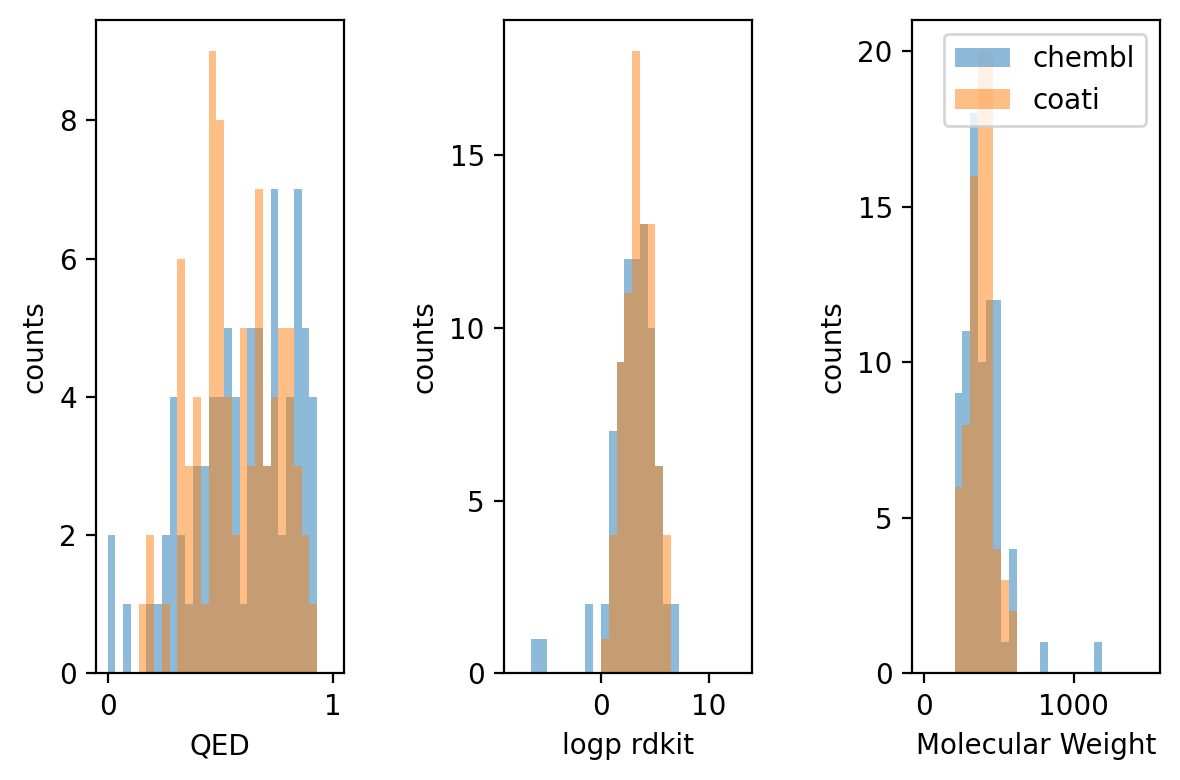

In [18]:
from matplotlib import pyplot as plt

plot_style = {
    "font.size": 10,
    "axes.titlesize": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 10,
    "font.family": "sans-serif",
    "font.serif": "Helvetica Neue",
    "text.usetex": "false",
}
with matplotlib.rc_context(plot_style):
    fig, ((ax0, ax1, ax2)) = plt.subplots(nrows=1, ncols=3, figsize=(6, 4), dpi=200)

    bins0 = np.linspace(0, 1, 30)
    _ = ax0.hist(
        [row["qed_rdkit"] for row in chembl_dict if "qed_rdkit" in row],
        bins=bins0,
        alpha=0.5,
        label="chembl",
    )
    _ = ax0.hist(
        [row["qed_rdkit"] for row in model_dict if "qed_rdkit" in row],
        bins=bins0,
        alpha=0.5,
        label="coati",
    )
    ax0.set_xlabel("QED")
    ax0.set_ylabel("counts")
    # ax0.legend()

    bins = np.linspace(-8, 13, 30)
    _ = ax1.hist(
        [row["logp_rdkit"] for row in chembl_dict if "logp_rdkit" in row],
        bins=bins,
        alpha=0.5,
        label="chembl",
    )
    _ = ax1.hist(
        [row["logp_rdkit"] for row in model_dict if "logp_rdkit" in row],
        bins=bins,
        alpha=0.5,
        label="coati",
    )
    ax1.set_xlabel("logp rdkit")
    ax1.set_ylabel("counts")
    # ax1.legend()

    bins2 = np.linspace(0, 1500, 30)

    _ = ax2.hist(
        [row["mw_rdkit"] for row in chembl_dict if "mw_rdkit" in row],
        bins=bins2,
        alpha=0.5,
        label="chembl",
    )
    _ = ax2.hist(
        [row["mw_rdkit"] for row in model_dict if "mw_rdkit" in row],
        bins=bins2,
        alpha=0.5,
        label="coati",
    )
    ax2.set_xlabel("Molecular Weight")
    ax2.set_ylabel("counts")
    ax2.legend()

    plt.tight_layout()
    plt.savefig("distributions.pdf", bbox_inches="tight")